In [1]:
import pandas as pd
import numpy as np
import keras.backend as K
import matplotlib.pyplot as plt
from scipy.misc import imshow
from sklearn.model_selection import train_test_split
from keras.models import Sequential
from keras.layers import Dense, Dropout, Activation, Flatten
from keras.layers import Conv2D, MaxPooling2D

from keras.models import model_from_json

%matplotlib inline




Using TensorFlow backend.


In [2]:

data = pd.read_csv("training.csv")
data = data.dropna()
data['Image'] = data['Image'].apply(lambda x: list(map(int, x.split(" "))))

data['Image'] = data['Image'].apply(lambda x: np.reshape(np.array(x), (96,96,1)))


In [3]:
X = list(data['Image'])
X = np.array(X).astype('float32')
print(X.shape)


y = data.drop('Image', axis=1).as_matrix().astype('float32')
print(y.shape)


X_train, X_test, y_train, y_test = train_test_split( X, y, test_size=0.15)
print(y_test.shape)

(2140, 96, 96, 1)
(2140, 30)
(321, 30)


In [4]:
input_shape = (96, 96, 1)
num_classes = 30

'''
model = Sequential()
model.add(Conv2D(32, kernel_size=(3, 3),activation='relu',input_shape=input_shape))
model.add(Conv2D(64, (3, 3), activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))
model.add(Flatten())
model.add(Dense(128, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(num_classes, activation='linear'))
'''


model = Sequential()
#Block 1
model.add(Conv2D(32, (3, 3), activation='relu', padding='same', input_shape=input_shape))
model.add(Conv2D(32, (3, 3), activation='relu', padding='same'))
model.add(MaxPooling2D(pool_size=(2, 2), strides=(2,2)))

#Block 2
model.add(Conv2D(64, (3, 3), activation='relu', padding='same'))
model.add(Conv2D(64, (3, 3), activation='relu', padding='same'))
model.add(MaxPooling2D(pool_size=(2, 2), strides=(2,2)))

#Block 3
model.add(Conv2D(128, (3, 3), activation='relu', padding='same'))
model.add(Conv2D(128, (3, 3), activation='relu', padding='same'))
model.add(MaxPooling2D(pool_size=(2, 2), strides=(2,2)))


model.add(Flatten())
model.add(Dense(256, activation='relu'))
model.add(Dense(num_classes, activation='linear'))


In [5]:
model.compile(loss='mean_squared_error',
              optimizer='Adam',
              metrics=['mse'])
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 96, 96, 32)        320       
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 96, 96, 32)        9248      
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 48, 48, 32)        0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 48, 48, 64)        18496     
_________________________________________________________________
conv2d_4 (Conv2D)            (None, 48, 48, 64)        36928     
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 24, 24, 64)        0         
_________________________________________________________________
conv2d_5 (Conv2D)            (None, 24, 24, 128)       73856     
__________

In [6]:
batch_size = 128
epochs = 500

history = model.fit(X_train, y_train,
          batch_size=batch_size,
          epochs=epochs,
          verbose=0,
          validation_data=(X_test, y_test))

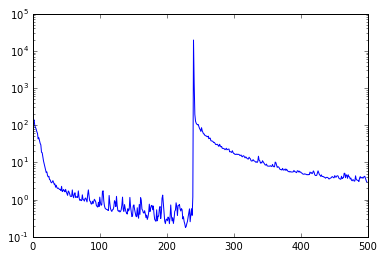

In [7]:
plt.figure()
ax = plt.gca()
ax.set_yscale("log")
plt.plot(history.history["loss"])

In [8]:
score = model.evaluate(X_test, y_test, verbose=0)
print('Test loss:', score[0])
print('Test accuracy:', score[1])

Test loss: 44.3308906555
Test accuracy: 44.3308906555


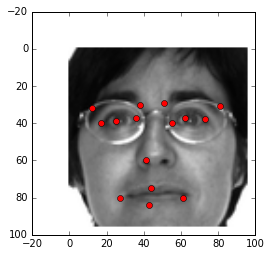

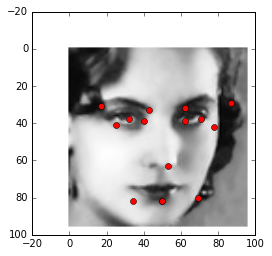

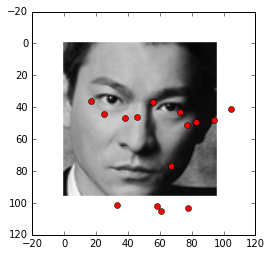

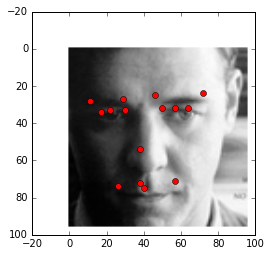

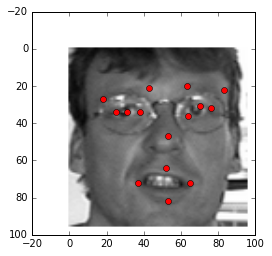

In [9]:
tests = [X_test[i].copy() for i in range(0,20,4)]
tests = [test.reshape(1,96,96,1) for test in tests]

preds = [np.clip(model.predict(test),0,255).astype('uint8')[0] for test in tests]
#print(preds)

for idx,test in enumerate(tests):
    plt.figure()

    plt.imshow(test.reshape((96,96)), cmap="gray")

    for i in range(0,len(preds[idx]),2):
        plt.plot(preds[idx][i],preds[idx][i+1], marker='o', color='r', ls='')
    plt.show()


In [10]:
model.save_weights("cnn_point.h5")
model_json = model.to_json()
with open("cnn_point_model.json", "w") as json_file:
    json_file.write(model_json)